In [11]:
import cv2
import numpy as np
from torchvision import transforms
import torch
from model import Net
from matplotlib import pyplot as plt

[[  0   0   0]
 [179 255  63]]
torch.Size([28, 28])
The number on screen is: 8


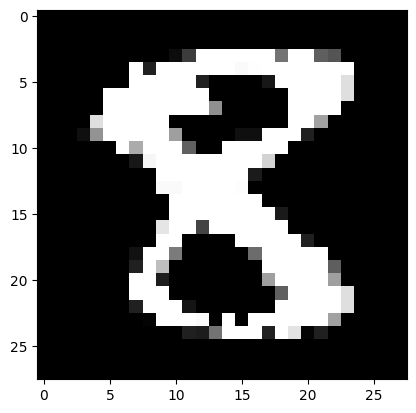

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

network = Net()
model_path = './results/sgdmodel.pth'
network_state_dict = torch.load(model_path)
network.load_state_dict(network_state_dict)

load_from_sys = True

if load_from_sys:
	hsv_value = np.load('hsv_value.npy')
	print(hsv_value)

cap = cv2.VideoCapture(0)
#res change
cap.set(3, 1280)
cap.set(4,720)
kernel = np.ones((5, 5), np.int8)
x1 = 0
y1 = 0

noise_thresh = 800

while True:
	_, frame = cap.read()
	# frame = cv2.flip(frame, 1)
	canvas = None
	if canvas is None:
		canvas = np.zeros_like(frame)

	#BGR standard opencv
	hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

	if load_from_sys:
		lower_range = hsv_value[0]
		upper_range = hsv_value[1]

	# mask = cv2.inRange(frame, upper_range, lower_range)
	mask = cv2.inRange(frame,lower_range, upper_range)
	mask = cv2.erode(mask, kernel, iterations = 1)
	mask = cv2.dilate(mask, kernel, iterations = 2)

	contours, heirarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	#findContour(s)

	if contours  and cv2.contourArea(max(contours, key = cv2.contourArea)) > noise_thresh:
		c = max(contours, key = cv2.contourArea	)
		x2, y2 ,w, h = cv2.boundingRect(c)
		padding=10
		x2-=padding
		y2 -= padding
		w += 2 * padding
		h += 2 * padding
		x2 = max(0, x2)
		y2 = max(0, y2)

		if x1 == 0 and y1 == 0:
			x1,y1 = x2,y2
		else:
			canvas = cv2.rectangle(canvas, (x2, y2), (x2 + w, y2 + h), [0, 255, 0], 4)

		x1,y1 = x2,y2
	
	else:
		x1,y1 = 0, 0

	combined = cv2.add(canvas, frame)

	stacked = np.hstack((frame, combined))
	cv2.imshow('Screen_Pen', cv2.resize(stacked, None, fx = 0.6, fy = 0.6))

	if cv2.waitKey(1) == 10:
		break

	#Clear the canvas when 'c' is pressed
	if cv2.waitKey(1) & 0xFF == ord('c'):
		canvas = None

	if cv2.waitKey(1) & 0xFF == ord('p'):
		roi = frame[y2:y2+h, x2:x2+w]
		gray_roi = cv2.inRange(roi, lower_range, upper_range)
		resized_roi = cv2.resize(gray_roi, (28, 28))
		tensor=transform(resized_roi)
		print(tensor.size())
		resized_tensor = torch.Tensor.view(tensor, (1, 1, 28, 28))
		network.eval()  # Set the model to evaluation mode
		with torch.no_grad():
			output = network(resized_tensor)	
		pred = output.argmax(dim=1, keepdim=True)
		print("The number on screen is: {}".format(int(pred)))
		grayscale_image_array =tensor.numpy()
		plt.imshow(grayscale_image_array, cmap='gray')
		plt.show()
		cv2.imwrite('./digits/digit.png', stacked)
		break




cv2.destroyAllWindows()
cap.release()